#

#

In [21]:
# required imports
import gzip
import json
import os
import re

# multi-array stuff
import pandas as pd
import numpy as np

# plot stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sea

# import and set no warnigns
import warnings
warnings.filterwarnings('ignore')

# set pd no max cols rows (to show all)
# FIXME: doesn't do anything
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

raw_adverts = []
for root, dirs, files in os.walk('../database/autovit/adverts/'):
    for name in files:
        file = os.path.join(root, name)
        with gzip.open(file, 'r') as fin:
            raw_adverts.extend(json.loads(fin.read().decode('utf-8')))

raw_adverts[0].pop('photos', None)
print('** Loaded {} adverts **'.format(len(raw_adverts)))

** Loaded 5067 adverts **


In [22]:
def strip_nr(str_nr):
    if str_nr is not None:
        return int(re.sub(r'[^0-9]+', '', str_nr))
    else:
        raise TypeError
    
def get_listing_param(data, name):
    for p in data['listing_params']:
        if p[0] == name:
            return p[1]
    else:
        return None


reshaped_adverts = []
i = 0
for ad in raw_adverts:
    # Ad has req data, essential
    if 'list_label' in ad \
        and get_listing_param(ad, 'Anul fabricatiei') is not None \
        and get_listing_param(ad, 'Kilometraj') is not None \
        and get_listing_param(ad, 'Combustibil') is not None \
        and 'features' in ad \
        and 'params' in ad:
        
        # reshape params data
        if 'params' in ad:
            for p in ad['params']:
                ad[p[0]] = p[1]
            # pop extra params
            ad.pop('params', None)

        # reshape features
        if 'features' in ad:
            for f in ad['features']:
                ad[f] = True
            # pop extra features
            ad.pop('features', None)

        # format price as int only
        if 'list_label' in ad:
            ad['price'] = strip_nr(ad['list_label'])
            ad.pop('list_label', None)
        else:
            print('No list label')


        ad['fabrication_year'] = strip_nr(get_listing_param(ad, 'Anul fabricatiei'))
        ad['kilometers'] = strip_nr(get_listing_param(ad, 'Kilometraj'))
        ad['fuel'] = get_listing_param(ad, 'Combustibil').lower()
        
        # Params
        hp = ad['Putere'] if 'Putere' in ad else None
        if hp is not None:
            hp = strip_nr(hp.replace('CP', ''))
            ad['horse_power'] = hp
            
        co2 = ad['Emisii CO2'] if 'Emisii CO2' in ad else None
        if co2 is not None:
            co2 = strip_nr(co2.replace('g/km', ''))
            ad['emissions'] = co2

        # Listing params
        cc = get_listing_param(ad, 'Capacitate cilindrica')
        if cc is not None:
            cc = strip_nr(cc.replace('cm3', ''))
            ad['cubic_capacity'] = cc



        # pop unused keys
        ad.pop('photos', None)
        ad.pop('description', None)

        reshaped_adverts.append(ad)

print('** Parsed usable adverts: {} **'.format(len(reshaped_adverts)))

** Parsed usable adverts: 4301 **


In [23]:
df = pd.DataFrame(reshaped_adverts)
df.describe()

,age,highlighted,urgent,topAd,category_id,business,hide_user_ads_button,dealer_logo_in_results,dealer_logo_in_ad_page,has_phone,has_email,map_radius,map_private_radius_size,ad_featured,price,fabrication_year,kilometers,horse_power,cubic_capacity,emissions
count,4301.000000,4301.0,4301.0,4301.000000,4301.0,4301.000000,4301.0,4301.000000,4301.000000,4282.0,4301.0,4301.000000,4301.0,4301.0,4301.000000,4301.000000,4.301000e+03,4230.000000,4201.000000,2617.000000
mean,75.539409,0.0,0.0,0.035341,29.0,0.502209,0.0,0.384794,0.422692,1.0,1.0,0.045106,2.0,0.0,17482.979307,2013.251802,1.496995e+05,162.685816,1977.693644,141.283913
std,166.788061,0.0,0.0,0.184661,0.0,0.500053,0.0,0.486603,0.494045,0.0,0.0,0.207560,0.0,0.0,24099.128292,4.917560,9.973002e+04,78.869881,613.137582,39.134531
min,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,500.000000,1982.000000,1.000000e+00,41.000000,600.000000,2.000000
25%,0.000000,0.0,0.0,0.000000,29.0,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,5500.000000,2010.000000,7.899900e+04,110.000000,1596.000000,115.000000
50%,28.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,2.0,0.0,9950.000000,2014.000000,1.593500e+05,143.000000,1968.000000,135.000000
75%,84.000000,0.0,0.0,0.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.000000,2.0,0.0,19500.000000,2017.000000,2.130000e+05,190.000000,1999.000000,159.000000
max,4039.000000,0.0,0.0,1.000000,29.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,1.000000,2.0,0.0,416500.000000,2021.000000,2.200000e+06,780.000000,6749.000000,400.000000


In [24]:
df.head()

,id,region_id,region_name,city_id,city_name,district_id,district_name,new_used,url,preview_url,title,title_description_full,created,age,highlighted,urgent,topAd,category_id,ad_packages,ad_features,subtitle,business,hide_user_ads_button,has_dealer_page_feature,status,dealer_logo_in_results,dealer_logo_in_ad_page,dealer_logo,stand_id,map_address,external_partner_code,partner_offer_url,fuel_type,is_promoted,dealer_info,header,header_type,has_phone,has_email,listing_params,map_zoom,map_lat,map_lon,map_radius,map_show_detailed,map_private_radius_size,show_map_for_private,city_label,person,user_label,user_ads_id,user_id,numeric_user_id,user_ads_url,list_label_ad,list_label_small,ad_homepage,ads_bighomepage,ad_featured,hasDealerPackageMapFeature,badges,Categorie,Adauga URL video YouTube,Marca,Model,Anul fabricatiei,Kilometraj,Combustibil,Putere,Capacitate cilindrica,Transmisie,Cutie de viteze,Norma de poluare,Caroserie,Numar de portiere,Culoare,Vopsea metalizata,Eligibil pentru finantare,Garantie dealer (inclusa in pret),Tara de origine,Fara accident in istoric,Carte de service,Numar anunt,Stare,ABS,Airbag-uri frontale,Airbag-uri laterale fata,CD,Computer de bord,Controlul stabilitatii (ESP),Geamuri fata electrice,Inchidere centralizata,Radio,Servodirectie,Aer conditionat,Aer conditionat doua zone,Airbag genunchi sofer,Airbag-uri cortina,Airbag-uri laterale spate,Bluetooth,Comenzi volan,Controlul tractiunii (ASR),Faruri automate,Faruri Xenon,Geamuri cu tenta,Geamuri spate electrice,Jante din aliaj usor,Lumini de zi (LED),Navigatie GPS,Oglinda retrovizoare interioara electrocromatica,Oglinzi retrovizoare exterioare electrocromatice,Oglinzi retrovizoare incalzite,Pilot automat,Proiectoare ceata,Scaune fata incalzite,Senzori parcare spate,Stergatoare parbriz automate,price,fabrication_year,kilometers,fuel,horse_power,cubic_capacity,Emisii CO2,Filtru de particule,Inmatriculat,Primul proprietar,Aer conditionat patru zone,Alarma,DVD,Geamuri laterale spate fumurii,Interior din piele,Limitator de viteza,Oglinzi retrovizoare ajustabile electric,Parbriz incalzit,Senzori parcare fata-spate,emissions,Versiune,Generatie,Data primei inmatriculari,Interior din velur,Imobilizator electronic,Intrare auxiliara,VIN,Tuning,Bare longitudinale acoperis,Camera parcare spate,Head-up display,Suspensie reglabila,Carlig remorca,Incalzire auxiliara,dealer_website,Acoperis panoramic,Garantie de la producator pana la,Scaune spate incalzite,Trapa,sau in limita a,Vopsea mata,TV,Masina de epoca,Vopsea nemetalizata,brand_program_id,brand_program_small_logo,Avariata,Volan pe dreapta,,Predare leasing,Plata initiala (la predare),Valoare rata lunara,Numar de rate lunare ramase,Valoare reziduala
0,7043759122,13,Timis,97411,Remetea Mare,,,used,https://www.autovit.ro/anunt/audi-a6-ID7GGTv6....,https://www.autovit.ro/i2/anunt/audi-a6-ID7GGT...,Audi A6,Audi A6,Azi 11:10,61,0,0,1,29,Gold,"[add_olx, vas_bundle_2]",[],1,0,False,active,1,1,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,,,,,"{'key': 'diesel', 'value': 'Diesel'}",True,"{'userType': 'Dealer', 'reliabilityBadgeUrl': ...",Anunturile zilei,promoted,1.0,1,"[[Anul fabricatiei, 2010 ], [Kilometraj, 294 0...",12,45.78521193,21.39325281,0,True,2,False,Remetea Mare,Roland Auto TM,Roland Auto TM,ciSm,ciSm,2932498,https://www.autovit.ro/i2/anunturi/user/ciSm/?...,6 990 EUR,\nSe emite factura,False,False,0,True,{'fast_response': True},Autoturisme,https://youtu.be/xqJv5Wn4gmY,Audi,A6,2010,294 000 km,Diesel,170 CP,1 968 cm3,Fata,Automata,Euro 5,Combi,5,Gri,Da,Da,12 luni,Germania,Da,Da,7043759122,Second hand,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,6990,2010,294000,diesel,170.0,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7044506685,42,Teleorman,69925,V

In [25]:
brand = df['title'].apply(lambda x : x.split(' ')[0])
# model = df['title'].apply(lambda x : x.split(' ')[1])
df.insert(3, "brand", brand)
# df.insert(3, "model", model)
# drop title on axis columns, replace in place dont return copy
df.drop(['title'], axis=1, inplace=True)
df.head()

,id,region_id,region_name,brand,city_id,city_name,district_id,district_name,new_used,url,preview_url,title_description_full,created,age,highlighted,urgent,topAd,category_id,ad_packages,ad_features,subtitle,business,hide_user_ads_button,has_dealer_page_feature,status,dealer_logo_in_results,dealer_logo_in_ad_page,dealer_logo,stand_id,map_address,external_partner_code,partner_offer_url,fuel_type,is_promoted,dealer_info,header,header_type,has_phone,has_email,listing_params,map_zoom,map_lat,map_lon,map_radius,map_show_detailed,map_private_radius_size,show_map_for_private,city_label,person,user_label,user_ads_id,user_id,numeric_user_id,user_ads_url,list_label_ad,list_label_small,ad_homepage,ads_bighomepage,ad_featured,hasDealerPackageMapFeature,badges,Categorie,Adauga URL video YouTube,Marca,Model,Anul fabricatiei,Kilometraj,Combustibil,Putere,Capacitate cilindrica,Transmisie,Cutie de viteze,Norma de poluare,Caroserie,Numar de portiere,Culoare,Vopsea metalizata,Eligibil pentru finantare,Garantie dealer (inclusa in pret),Tara de origine,Fara accident in istoric,Carte de service,Numar anunt,Stare,ABS,Airbag-uri frontale,Airbag-uri laterale fata,CD,Computer de bord,Controlul stabilitatii (ESP),Geamuri fata electrice,Inchidere centralizata,Radio,Servodirectie,Aer conditionat,Aer conditionat doua zone,Airbag genunchi sofer,Airbag-uri cortina,Airbag-uri laterale spate,Bluetooth,Comenzi volan,Controlul tractiunii (ASR),Faruri automate,Faruri Xenon,Geamuri cu tenta,Geamuri spate electrice,Jante din aliaj usor,Lumini de zi (LED),Navigatie GPS,Oglinda retrovizoare interioara electrocromatica,Oglinzi retrovizoare exterioare electrocromatice,Oglinzi retrovizoare incalzite,Pilot automat,Proiectoare ceata,Scaune fata incalzite,Senzori parcare spate,Stergatoare parbriz automate,price,fabrication_year,kilometers,fuel,horse_power,cubic_capacity,Emisii CO2,Filtru de particule,Inmatriculat,Primul proprietar,Aer conditionat patru zone,Alarma,DVD,Geamuri laterale spate fumurii,Interior din piele,Limitator de viteza,Oglinzi retrovizoare ajustabile electric,Parbriz incalzit,Senzori parcare fata-spate,emissions,Versiune,Generatie,Data primei inmatriculari,Interior din velur,Imobilizator electronic,Intrare auxiliara,VIN,Tuning,Bare longitudinale acoperis,Camera parcare spate,Head-up display,Suspensie reglabila,Carlig remorca,Incalzire auxiliara,dealer_website,Acoperis panoramic,Garantie de la producator pana la,Scaune spate incalzite,Trapa,sau in limita a,Vopsea mata,TV,Masina de epoca,Vopsea nemetalizata,brand_program_id,brand_program_small_logo,Avariata,Volan pe dreapta,,Predare leasing,Plata initiala (la predare),Valoare rata lunara,Numar de rate lunare ramase,Valoare reziduala
0,7043759122,13,Timis,Audi,97411,Remetea Mare,,,used,https://www.autovit.ro/anunt/audi-a6-ID7GGTv6....,https://www.autovit.ro/i2/anunt/audi-a6-ID7GGT...,Audi A6,Azi 11:10,61,0,0,1,29,Gold,"[add_olx, vas_bundle_2]",[],1,0,False,active,1,1,https://ireland.apollo.olxcdn.com/v1/files/eyJ...,,,,,"{'key': 'diesel', 'value': 'Diesel'}",True,"{'userType': 'Dealer', 'reliabilityBadgeUrl': ...",Anunturile zilei,promoted,1.0,1,"[[Anul fabricatiei, 2010 ], [Kilometraj, 294 0...",12,45.78521193,21.39325281,0,True,2,False,Remetea Mare,Roland Auto TM,Roland Auto TM,ciSm,ciSm,2932498,https://www.autovit.ro/i2/anunturi/user/ciSm/?...,6 990 EUR,\nSe emite factura,False,False,0,True,{'fast_response': True},Autoturisme,https://youtu.be/xqJv5Wn4gmY,Audi,A6,2010,294 000 km,Diesel,170 CP,1 968 cm3,Fata,Automata,Euro 5,Combi,5,Gri,Da,Da,12 luni,Germania,Da,Da,7043759122,Second hand,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,6990,2010,294000,diesel,170.0,1968.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7044506685,42,Teleorman,Audi,69925

In [26]:
df.brand.unique()

array(['Audi', 'Volkswagen', 'Opel', 'Citroën', 'BMW', 'Ford', 'Seat',
       'Skoda', 'Mercedes-Benz', 'Aston', 'Volvo', 'Renault',
       'Mitsubishi', 'Mazda', 'Dacia', 'Porsche', 'Land', 'Kia', 'Honda',
       'Jaguar', 'Alfa', 'Subaru', 'Nissan', 'Toyota', 'Fiat', 'Suzuki',
       'Saab', 'Hyundai', 'Dodge', 'Lexus', 'Peugeot', 'Daihatsu', 'Mini',
       'Jeep', 'Infiniti', 'Smart', 'SsangYong', 'Lancia', 'Chrysler',
       'Rover', 'Bentley', 'Maserati', 'Rolls-Royce', 'Lamborghini',
       'Abarth', 'Chevrolet', 'Tesla', 'Ferrari'], dtype=object)

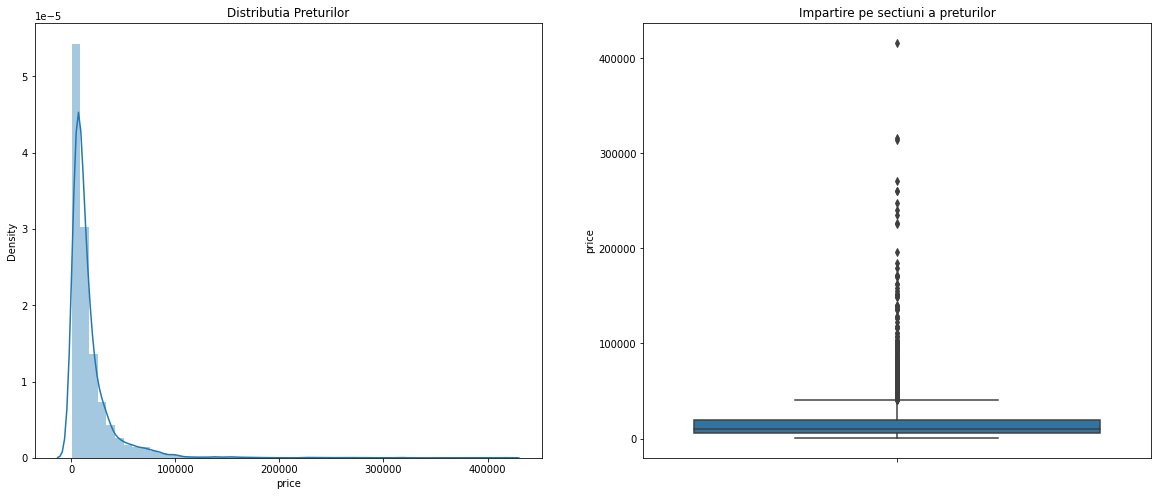

In [27]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('Distributia Preturilor')
sea.distplot(df['price'])

plt.subplot(1, 2, 2)
plt.title('Impartire pe sectiuni a preturilor')
sea.boxplot(y=df['price'])

plt.show()

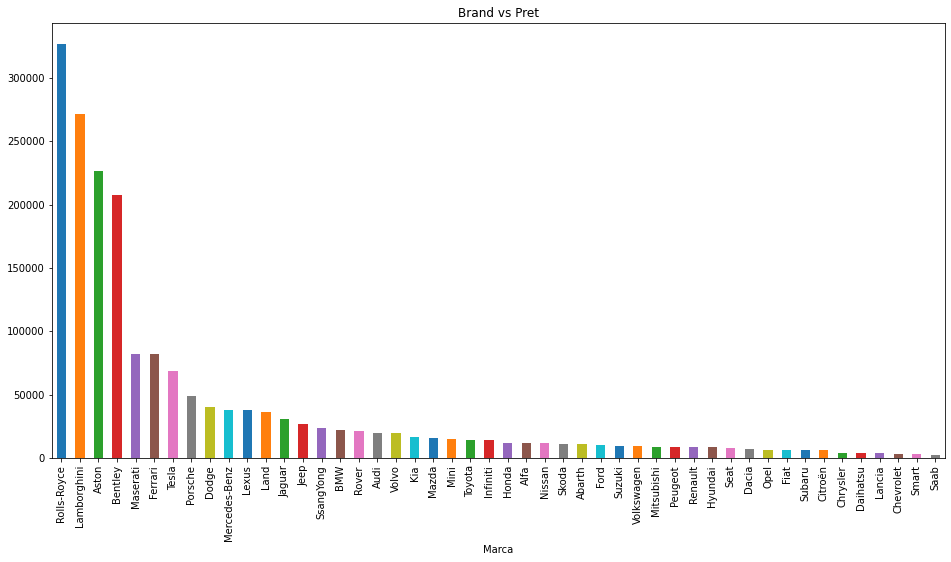

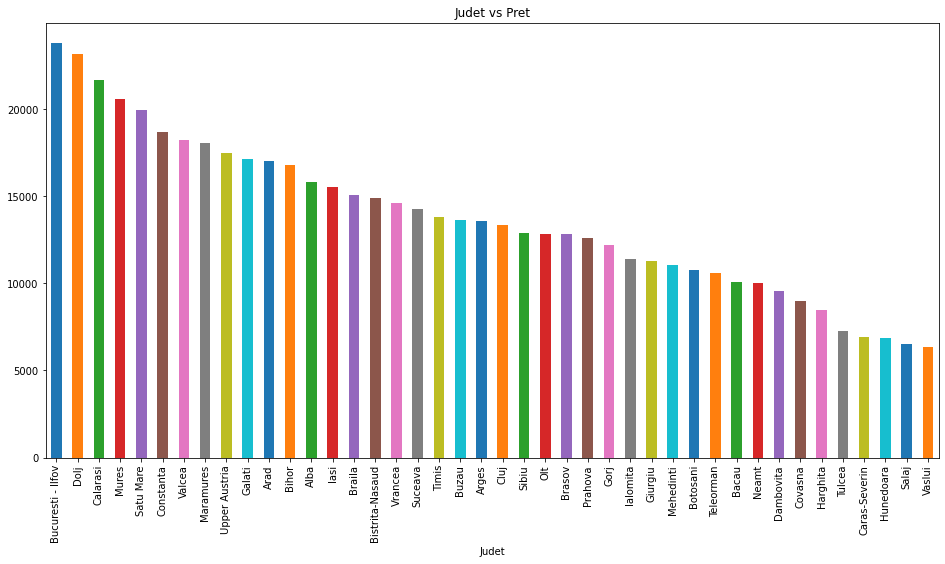

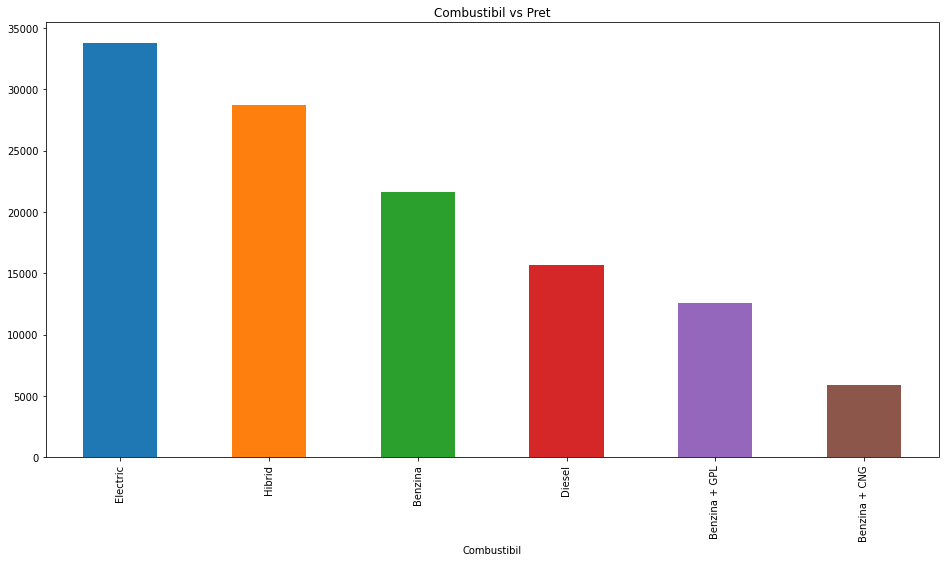

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, (1, 4))
df_brand = df.groupby(['brand'])['price'].mean().sort_values(ascending = False)
plt1 = df_brand.plot(
    xlabel="Marca",
    kind="bar",
    color=plt.cm.tab10(np.arange(len(df.brand)) % plt.cm.tab10.N)
)
plt.title('Brand vs Pret')
plt.show()

plt.figure(figsize=(16, 8))
plt.subplot(2, 1, (1, 2))
df_cc = df.groupby(['region_name'])['price'].mean().sort_values(ascending = False)
df_cc.plot(
    xlabel="Judet",
    kind="bar",
    color=plt.cm.tab10(np.arange(len(df.region_name)) % plt.cm.tab10.N)
)
plt.title('Judet vs Pret')
plt.show()

plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)
df_fuel = df.groupby(['Combustibil'])['price'].mean().sort_values(ascending = False)
plt1 = df_fuel.plot(
    xlabel="Combustibil",
    kind="bar", 
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.title('Combustibil vs Pret')
plt.show()

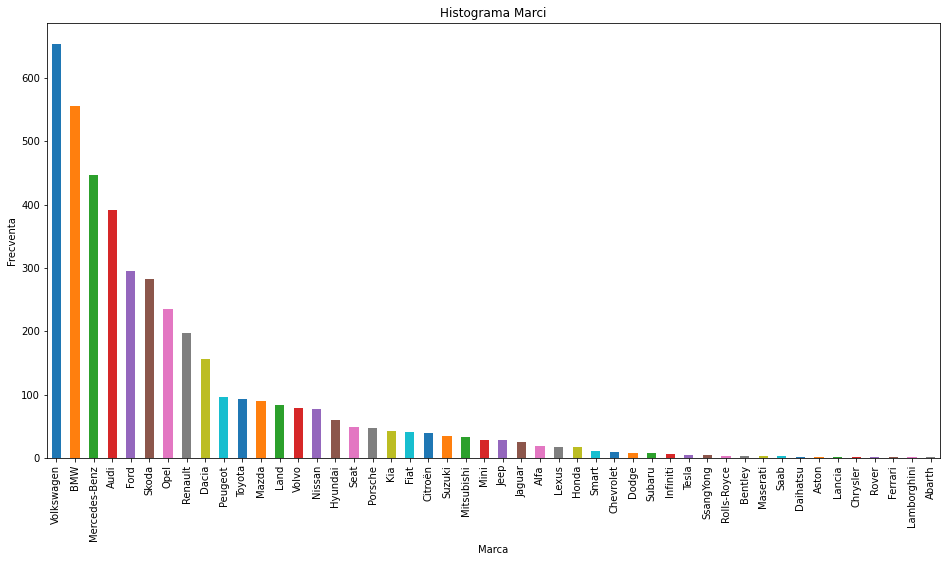

In [29]:
plt.figure(figsize=(16, 8))
plt1 = df.brand.value_counts().plot(
    kind='bar', 
    color=plt.cm.tab10(np.arange(len(df.brand)) % plt.cm.tab10.N)
)
plt.title('Histograma Marci')
plt1.set(xlabel = 'Marca', ylabel='Frecventa')

plt.show()

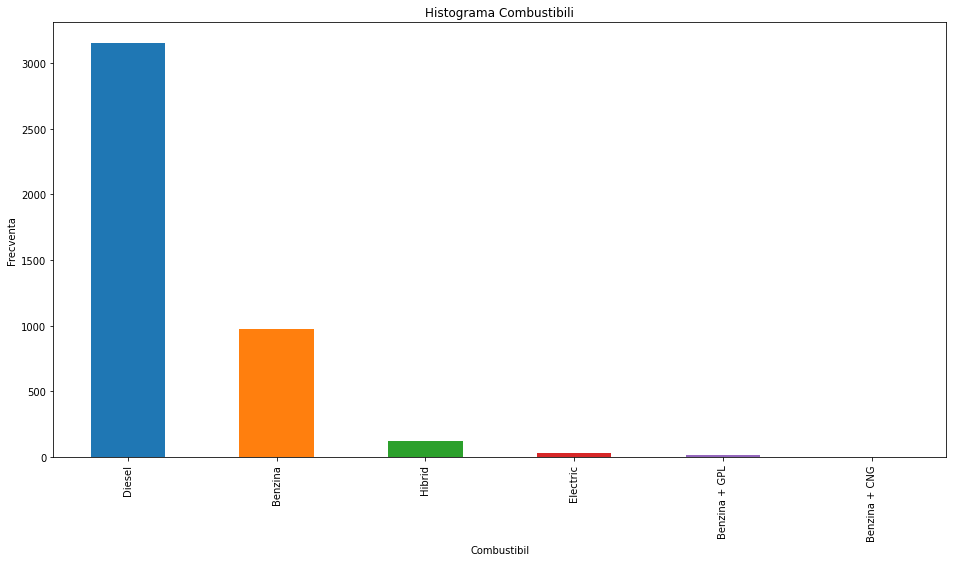

In [30]:
plt.figure(figsize=(16, 8))
plt1 = df.Combustibil.value_counts().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.Combustibil)) % plt.cm.tab10.N)
)
plt.title('Histograma Combustibili')
plt1.set(xlabel = 'Combustibil', ylabel='Frecventa')

plt.show()

[Text(0.5, 0, 'Caroserie'), Text(0, 0.5, 'Frecventa')]

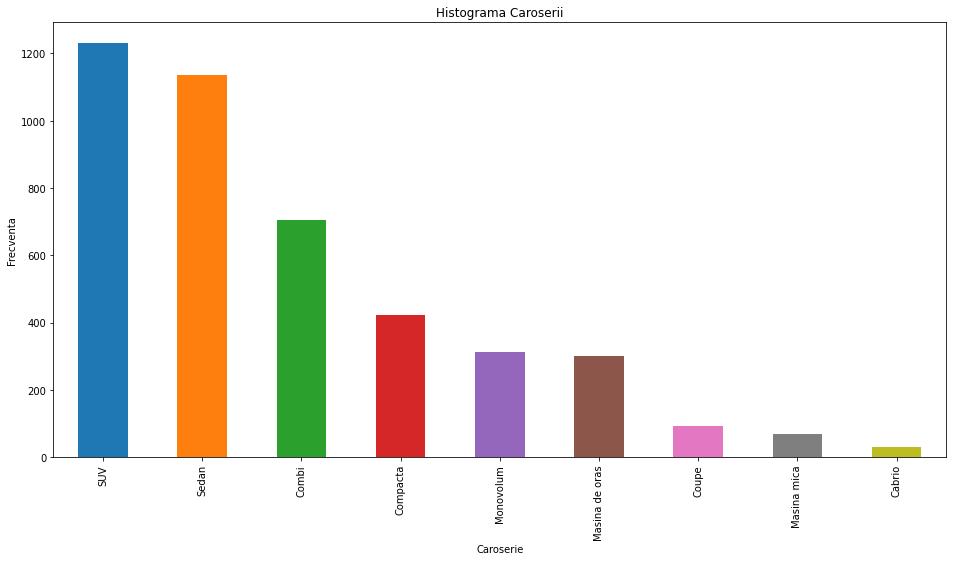

In [31]:
plt.figure(figsize=(16, 8))
plt1 = df.Caroserie.value_counts().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.Caroserie)) % plt.cm.tab10.N)
)
plt.title('Histograma Caroserii')
plt1.set(xlabel = 'Caroserie', ylabel='Frecventa')

[Text(0.5, 0, 'An'), Text(0, 0.5, 'Frecventa')]

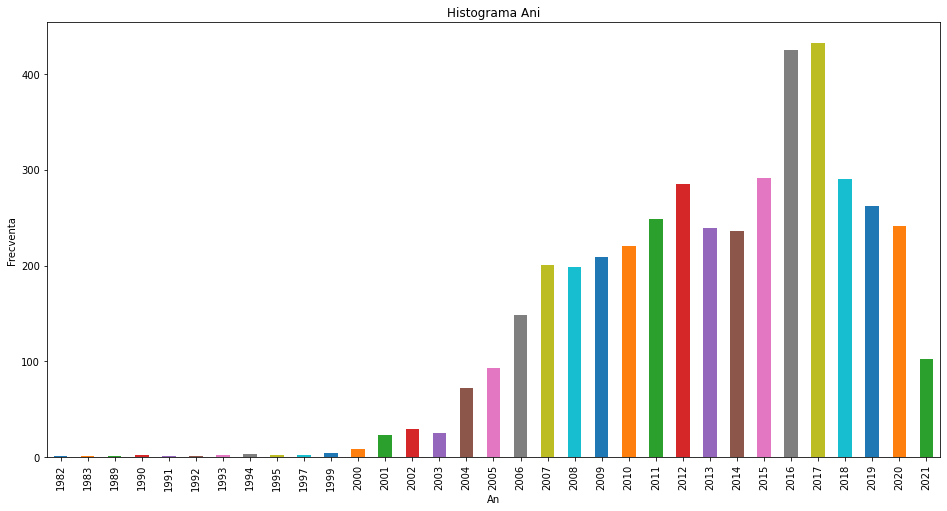

In [32]:
plt.figure(figsize=(16, 8))
plt1 = df.fabrication_year.value_counts().sort_index().plot(
    kind='bar',
    color=plt.cm.tab10(np.arange(len(df.fabrication_year)) % plt.cm.tab10.N)
)

plt.title('Histograma Ani')
plt1.set(xlabel = 'An', ylabel='Frecventa')

## Numerical data visualization

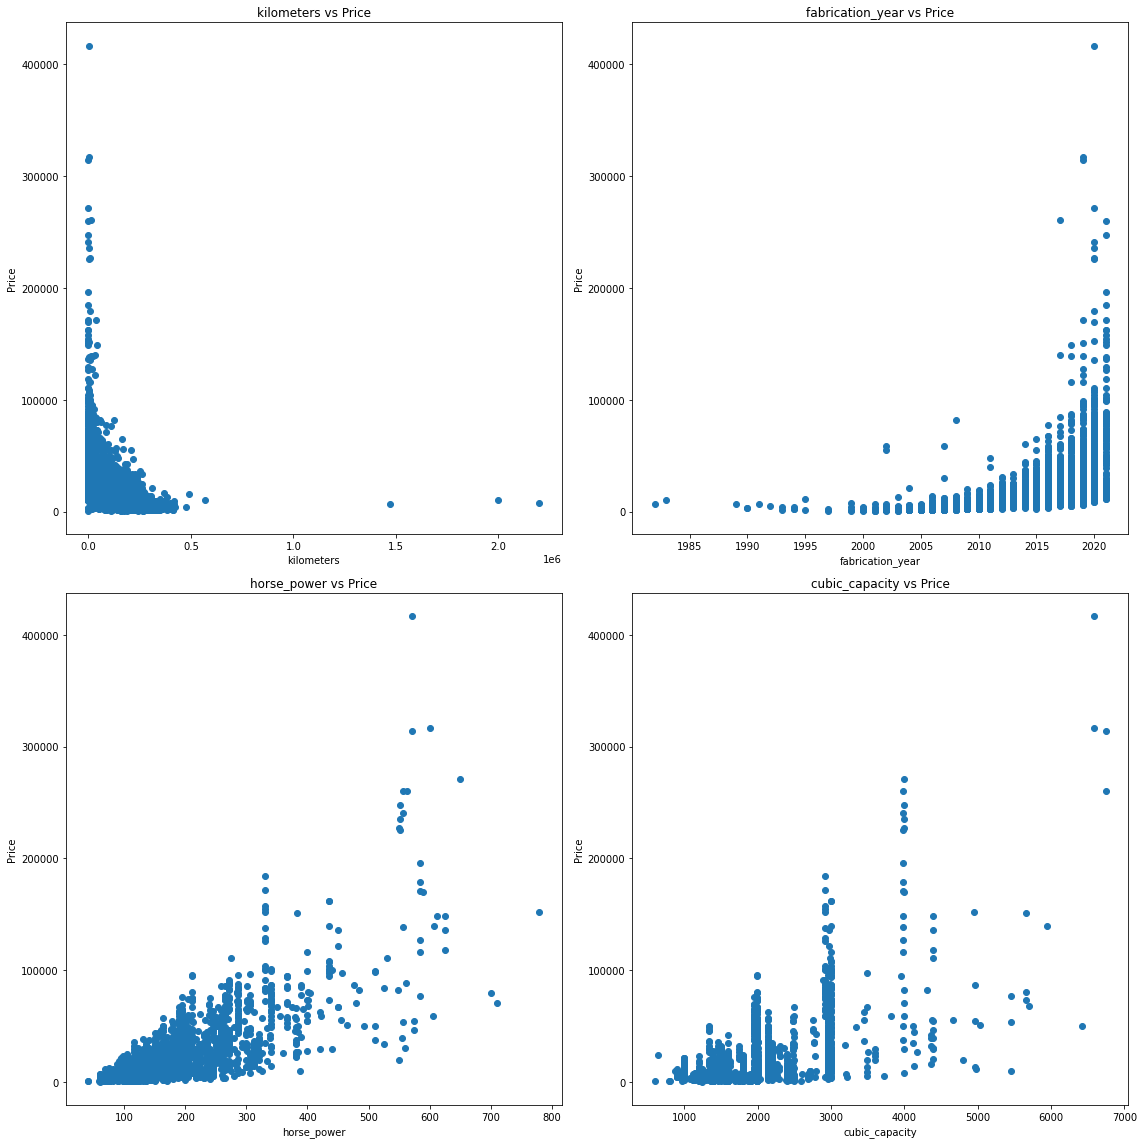

In [33]:
def scatter(x, fig):
    plt.subplot(2, 2, fig)
    plt.scatter(df[x], df['price'])
    plt.title(x+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

plt.figure(figsize=(16, 16))
# todo, remove KM outliers => plot km only up to ~ 500k KM
scatter('kilometers', 1)
scatter('fabrication_year', 2)
scatter('horse_power', 3)
scatter('cubic_capacity', 4)

plt.tight_layout()

### 

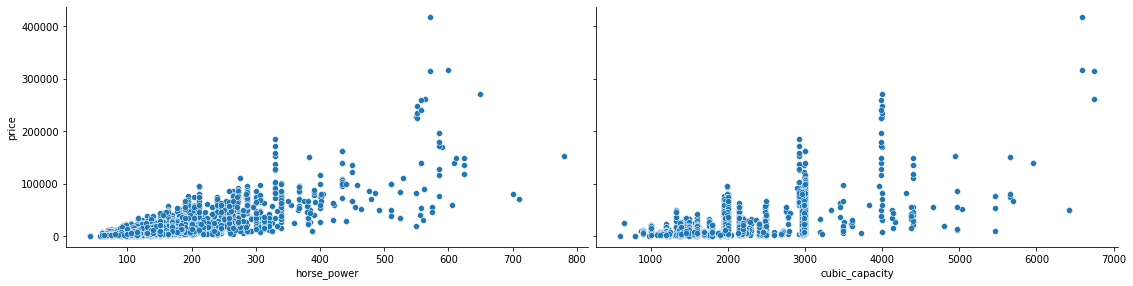

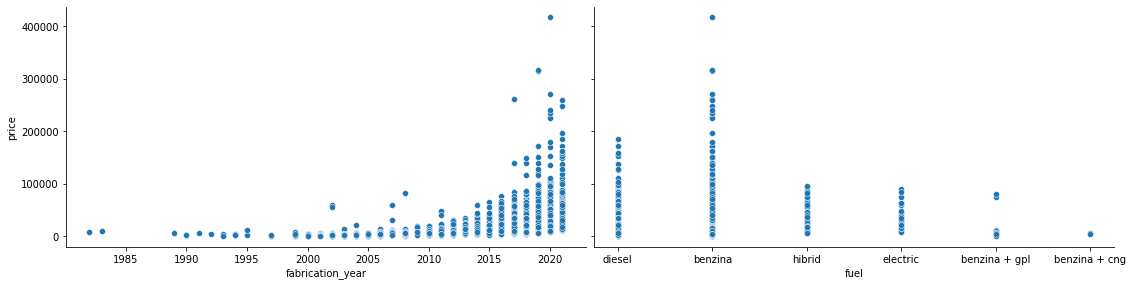

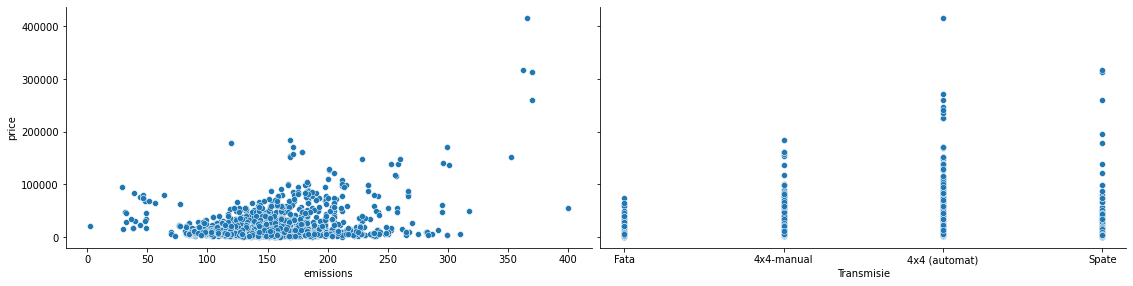

In [34]:
def pp(x, y):
    sea.pairplot(df, x_vars=[x, y], y_vars='price', height=4, aspect=2, kind='scatter')
    plt.show()

pp('horse_power', 'cubic_capacity')
pp('fabrication_year', 'fuel')
pp('emissions', 'Transmisie')
# TODO numerical date first registere

## Building a model

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

cols = ('fabrication_year', 'horse_power')

X = df.loc[:, cols]
y = df['price']

X.loc[:, cols] = scale.fit_transform(X[[*cols]].values)

model = sm.OLS(y, X, missing='drop').fit()

model.summary()

In [ ]:
car = [2009, 230]

scaled_car = scale.transform([car])
prediction = model.predict(scaled_car[0])

print('Estimated market price: %d EUR' % int(prediction))